# Main Analysis Integration Tests

This notebook provides comprehensive validation tests for `main_analysis.py` with detailed variable inspection and message output.

## Test Coverage:
1. H5 file structure validation (column names and metadata)
2. Plot functionality with metadata/column application and non-ASCII exclusion
3. NaN data handling and propagation in mathematical operations
4. Enhanced plotting features
5. Dask-based parallel processing workflow

## Usage:
Run each cell sequentially to inspect variables and intermediate results.


In [1]:
# Setup and imports
import sys
from pathlib import Path

# Add project root to path
current_dir = Path.cwd()
ifi_root = current_dir.parent if current_dir.name == "analysis" else current_dir
sys.path.insert(0, str(ifi_root))

from ifi.utils.cache_setup import setup_project_cache
cache_config = setup_project_cache()
print(f"Cache configured: {cache_config['cache_dir']}")

import numpy as np
import pandas as pd
import h5py
import tempfile
import shutil
from unittest.mock import Mock, patch
import matplotlib.pyplot as plt

from ifi.analysis.main_analysis import load_and_process_file, run_analysis
from ifi.utils import file_io
from ifi.analysis import plots
from ifi.db_controller.nas_db import NAS_DB
from ifi.db_controller.vest_db import VEST_DB

print("✓ All imports successful")


Using cache directory: C:\Users\dhkdw\Documents\mygit\ifi\cache\numba_cache
Numba threading layer: omp
Project cache configured successfully.
Cache configured: C:\Users\dhkdw\Documents\mygit\ifi\cache\numba_cache
✓ All imports successful


## Test Data Preparation

Create sample DataFrames for testing with various characteristics.


In [2]:
# Create sample DataFrame with metadata
fs = 50e6
duration = 0.01
n_samples = int(fs * duration)
t = np.linspace(0, duration, n_samples)

sample_dataframe = pd.DataFrame({
    "TIME": t,
    "CH0": np.sin(2 * np.pi * 8e6 * t),
    "CH1": np.cos(2 * np.pi * 8e6 * t),
    "CH2": np.sin(2 * np.pi * 8e6 * t + np.pi / 4),
})

# Add metadata
sample_dataframe.attrs["source_file_type"] = "csv"
sample_dataframe.attrs["source_file_format"] = "MSO58"
sample_dataframe.attrs["metadata"] = {
    "record_length": n_samples,
    "time_resolution": 1 / fs,
    "sampling_rate": fs,
}

print(f"Sample DataFrame shape: {sample_dataframe.shape}")
print(f"Columns: {list(sample_dataframe.columns)}")
print(f"Metadata: {sample_dataframe.attrs}")
print(f"\nFirst 5 rows:")
print(sample_dataframe.head())


Sample DataFrame shape: (500000, 4)
Columns: ['TIME', 'CH0', 'CH1', 'CH2']
Metadata: {'source_file_type': 'csv', 'source_file_format': 'MSO58', 'metadata': {'record_length': 500000, 'time_resolution': 2e-08, 'sampling_rate': 50000000.0}}

First 5 rows:
           TIME       CH0       CH1       CH2
0  0.000000e+00  0.000000  1.000000  0.707107
1  2.000004e-08  0.844329  0.535825  0.975916
2  4.000008e-08  0.904825 -0.425783  0.338734
3  6.000012e-08  0.125327 -0.992115 -0.612912
4  8.000016e-08 -0.770518 -0.637418 -0.995561


In [3]:
# Create DataFrame with NaN values
sample_dataframe_with_nan = pd.DataFrame({
    "TIME": t,
    "CH0": np.sin(2 * np.pi * 8e6 * t),
    "CH1": np.cos(2 * np.pi * 8e6 * t),
})

# Introduce NaN values at specific positions
sample_dataframe_with_nan.loc[100:200, "CH0"] = np.nan
sample_dataframe_with_nan.loc[300:350, "CH1"] = np.nan

sample_dataframe_with_nan.attrs["source_file_type"] = "csv"
sample_dataframe_with_nan.attrs["metadata"] = {"record_length": n_samples}

initial_nan_count = sample_dataframe_with_nan.isna().sum().sum()
print(f"DataFrame with NaN - Shape: {sample_dataframe_with_nan.shape}")
print(f"Total NaN values: {initial_nan_count}")
print(f"NaN per column:\n{sample_dataframe_with_nan.isna().sum()}")
print(f"\nNaN positions in CH0: {sample_dataframe_with_nan['CH0'].isna().sum()} values")
print(f"NaN positions in CH1: {sample_dataframe_with_nan['CH1'].isna().sum()} values")


DataFrame with NaN - Shape: (500000, 3)
Total NaN values: 152
NaN per column:
TIME      0
CH0     101
CH1      51
dtype: int64

NaN positions in CH0: 101 values
NaN positions in CH1: 51 values


In [4]:
# Create DataFrame with Korean characters in column names
sample_dataframe_with_korean = pd.DataFrame({
    "TIME": t,
    "한글컬럼": np.sin(2 * np.pi * 8e6 * t),  # Korean column name
    "CH0": np.cos(2 * np.pi * 8e6 * t),
})

sample_dataframe_with_korean.attrs["source_file_type"] = "csv"
sample_dataframe_with_korean.attrs["metadata"] = {"record_length": n_samples}

print(f"DataFrame with Korean columns - Shape: {sample_dataframe_with_korean.shape}")
print(f"Columns: {list(sample_dataframe_with_korean.columns)}")
print(f"Column with Korean: '한글컬럼' (length={len('한글컬럼')} characters)")


DataFrame with Korean columns - Shape: (500000, 3)
Columns: ['TIME', '한글컬럼', 'CH0']
Column with Korean: '한글컬럼' (length=4 characters)


## 1. H5 File Structure Validation

Test H5 file structure, column names, and metadata preservation.


In [5]:
# Test 1.1: H5 Save and Load Structure
print("=" * 80)
print("Test 1.1: H5 Save and Load Structure")
print("=" * 80)

# Create temporary directory
tmp_dir = Path(tempfile.mkdtemp())
h5_dir = tmp_dir / "results" / "45821"
h5_dir.mkdir(parents=True, exist_ok=True)
print(f"Temporary directory: {h5_dir}")

shot_num = 45821

# Prepare test data
signals = {"test_file.csv": sample_dataframe}
stft_results = {}
cwt_results = {}
density_data = pd.DataFrame({
    "ne_CH0_test": np.random.randn(len(sample_dataframe)),
    "ne_CH1_test": np.random.randn(len(sample_dataframe)),
})
vest_data = pd.DataFrame({
    "ip": np.random.randn(1000),
    "time": np.linspace(0, 1, 1000),
})

print(f"\nData preparation:")
print(f"  - Signals: {len(signals)} files")
print(f"  - Density data shape: {density_data.shape}")
print(f"  - VEST data shape: {vest_data.shape}")

# Save to H5
saved_h5_path = file_io.save_results_to_hdf5(
    str(h5_dir),
    shot_num,
    signals,
    stft_results,
    cwt_results,
    density_data,
    vest_data,
)

print(f"\n✓ H5 file saved: {saved_h5_path}")
print(f"  File exists: {Path(saved_h5_path).exists()}")
print(f"  File size: {Path(saved_h5_path).stat().st_size / 1024:.2f} KB")


Test 1.1: H5 Save and Load Structure
Temporary directory: C:\Users\dhkdw\AppData\Local\Temp\tmpumhpz2wi\results\45821

Data preparation:
  - Signals: 1 files
  - Density data shape: (500000, 2)
  - VEST data shape: (1000, 2)
Results saved to: C:\Users\dhkdw\AppData\Local\Temp\tmpumhpz2wi\results\45821\45821.h5

✓ H5 file saved: C:\Users\dhkdw\AppData\Local\Temp\tmpumhpz2wi\results\45821\45821.h5
  File exists: True
  File size: 23467.12 KB


In [ ]:
# Validate H5 structure
print("\n" + "=" * 80)
print("Validating H5 Structure")
print("=" * 80)

with h5py.File(saved_h5_path, "r") as hf:
    print(f"\nTop-level groups: {list(hf.keys())}")
    
    # Check metadata
    print("\n--- Metadata Group ---")
    if "metadata" in hf:
        metadata_group = hf["metadata"]
        print(f"  ✓ Metadata group exists")
        print(f"  Attributes: {list(metadata_group.attrs.keys())}")
        for key, value in metadata_group.attrs.items():
            print(f"    {key}: {value}")
    else:
        print("  ✗ Metadata group missing!")
    
    # Check signals
    print("\n--- Signals Group ---")
    if "signals" in hf:
        signals_group = hf["signals"]
        print(f"  ✓ Signals group exists")
        if signals_group.attrs.get("empty", False):
            print("  ⚠ Signals group is empty")
        else:
            print(f"  Signal files: {list(signals_group.keys())}")
            for signal_name in signals_group.keys():
                signal_group = signals_group[signal_name]
                print(f"    {signal_name}:")
                print(f"      Columns: {list(signal_group.keys())}")
                for col_name in signal_group.keys():
                    col_data = signal_group[col_name]
                    print(f"        {col_name}: shape={col_data.shape}, dtype={col_data.dtype}")
    else:
        print("  ✗ Signals group missing!")
    
    # Check density data
    print("\n--- Density Data Group ---")
    if "density_data" in hf:
        density_group = hf["density_data"]
        print(f"  ✓ Density data group exists")
        print(f"  Columns: {list(density_group.keys())}")
        for col_name in density_group.keys():
            col_data = density_group[col_name]
            print(f"    {col_name}: shape={col_data.shape}, dtype={col_data.dtype}")
    else:
        print("  ✗ Density data group missing!")
    
    # Check VEST data
    print("\n--- VEST Data Group ---")
    if "vest_data" in hf:
        vest_group = hf["vest_data"]
        print(f"  ✓ VEST data group exists")
        print(f"  Columns: {list(vest_group.keys())}")
        for col_name in vest_group.keys():
            col_data = vest_group[col_name]
            print(f"    {col_name}: shape={col_data.shape}, dtype={col_data.dtype}")
    else:
        print("  ✗ VEST data group missing!")

print("\n✓ H5 structure validation complete")



Validating H5 Structure

Top-level groups: ['density_data', 'metadata', 'signals', 'vest_data']

--- Metadata Group ---
  ✓ Metadata group exists
  Attributes: ['created_at', 'ifi_version', 'shot_number']
    created_at: 2025-11-10T11:57:15.865912
    ifi_version: 1.0
    shot_number: 45821

--- Signals Group ---
  ✓ Signals group exists
  Signal files: ['test_file.csv']
    test_file.csv:
      Columns: ['CH0', 'CH1', 'CH2', 'TIME']
        CH0: shape=(500000,), dtype=float64
        CH1: shape=(500000,), dtype=float64
        CH2: shape=(500000,), dtype=float64
        TIME: shape=(500000,), dtype=float64

--- Density Data Group ---
  ✓ Density data group exists
  Columns: ['ne_CH0_test', 'ne_CH1_test']
    ne_CH0_test: shape=(500000,), dtype=float64
    ne_CH1_test: shape=(500000,), dtype=float64

--- VEST Data Group ---
  ✓ VEST data group exists
  Columns: ['ip', 'time']
    ip: shape=(1000,), dtype=float64
    time: shape=(1000,), dtype=float64

✓ H5 structure validation complet

In [7]:
# Test 1.2: H5 Column Names Validation
print("=" * 80)
print("Test 1.2: H5 Column Names Validation")
print("=" * 80)

# Save DataFrame with specific column names
signals_test = {"test_file.csv": sample_dataframe}
h5_path_cols = file_io.save_results_to_hdf5(
    str(h5_dir),
    shot_num,
    signals_test,
    {},
    {},
    pd.DataFrame(),
    pd.DataFrame(),
)

# Load and verify column names
with h5py.File(h5_path_cols, "r") as hf:
    signal_group = hf["signals"]["test_file.csv"]
    saved_columns = list(signal_group.keys())
    
    print(f"\nOriginal columns: {list(sample_dataframe.columns)}")
    print(f"Saved columns: {saved_columns}")
    
    # Check column preservation
    original_cols = set(sample_dataframe.columns)
    saved_cols = set(saved_columns)
    
    if original_cols == saved_cols:
        print("  ✓ All columns preserved correctly")
    else:
        print(f"  ✗ Column mismatch!")
        print(f"    Missing: {original_cols - saved_cols}")
        print(f"    Extra: {saved_cols - original_cols}")
    
    print(f"\nColumn count: {len(saved_columns)} (expected: {len(sample_dataframe.columns)})")
    
    # Display column details
    print("\nColumn details:")
    for col in saved_columns:
        col_data = signal_group[col]
        print(f"  {col}: shape={col_data.shape}, dtype={col_data.dtype}, size={col_data.size}")

print("\n✓ Column names validation complete")


Test 1.2: H5 Column Names Validation
Results saved to: C:\Users\dhkdw\AppData\Local\Temp\tmpumhpz2wi\results\45821\45821.h5

Original columns: ['TIME', 'CH0', 'CH1', 'CH2']
Saved columns: ['CH0', 'CH1', 'CH2', 'TIME']
  ✓ All columns preserved correctly

Column count: 4 (expected: 4)

Column details:
  CH0: shape=(500000,), dtype=float64, size=500000
  CH1: shape=(500000,), dtype=float64, size=500000
  CH2: shape=(500000,), dtype=float64, size=500000
  TIME: shape=(500000,), dtype=float64, size=500000

✓ Column names validation complete


In [8]:
# Test 1.3: H5 Metadata Preservation
print("=" * 80)
print("Test 1.3: H5 Metadata Preservation")
print("=" * 80)

signals_meta = {"test_file.csv": sample_dataframe}
h5_path_meta = file_io.save_results_to_hdf5(
    str(h5_dir),
    shot_num,
    signals_meta,
    {},
    {},
    pd.DataFrame(),
    pd.DataFrame(),
)

# Load results back
loaded_results = file_io.load_results_from_hdf5(shot_num, str(h5_dir.parent.parent))

if loaded_results:
    print(f"\n✓ Results loaded successfully")
    print(f"  Keys in loaded results: {list(loaded_results.keys())}")
    
    if "metadata" in loaded_results:
        print(f"\n  Loaded metadata:")
        for key, value in loaded_results["metadata"].items():
            print(f"    {key}: {value}")
        
        # Compare with original
        if loaded_results["metadata"]["shot_number"] == shot_num:
            print(f"  ✓ Shot number preserved: {shot_num}")
        else:
            print(f"  ✗ Shot number mismatch: {loaded_results['metadata']['shot_number']} != {shot_num}")
    else:
        print("  ✗ Metadata not found in loaded results")
else:
    print("  ✗ Failed to load results")

print("\n✓ Metadata preservation test complete")


Test 1.3: H5 Metadata Preservation
Results saved to: C:\Users\dhkdw\AppData\Local\Temp\tmpumhpz2wi\results\45821\45821.h5
No results found for shot 45821
  ✗ Failed to load results

✓ Metadata preservation test complete


## 2. Plot Validation

Test plot functionality with metadata/column application and non-ASCII exclusion.


In [ ]:
# Test 2.1: Plot Metadata Application
print("=" * 80)
print("Test 2.1: Plot Metadata Application")
print("=" * 80)

plotter = plots.Plotter()

# Extract metadata info
metadata_str = plotter._extract_metadata_info(sample_dataframe)

print(f"\nExtracted metadata string:")
print(f"  '{metadata_str}'")
print(f"\nMetadata components:")
if metadata_str:
    components = metadata_str.split(" | ")
    for comp in components:
        print(f"    - {comp}")
    
    # Check for expected components
    has_type = "Type:" in metadata_str or "Format:" in metadata_str
    has_length = "Length:" in metadata_str or "Resolution:" in metadata_str
    
    print(f"\n  ✓ Contains type/format: {has_type}")
    print(f"  ✓ Contains length/resolution: {has_length}")
else:
    print("  ⚠ No metadata extracted")

print("\n✓ Metadata application test complete")


Test 2.1: Plot Metadata Application

Extracted metadata string:
  'Type: csv | Format: MSO58 | Length: 500000 | Resolution: 20.0 ns'

Metadata components:
    - Type: csv
    - Format: MSO58
    - Length: 500000
    - Resolution: 20.0 ns

  ✓ Contains type/format: True
  ✓ Contains length/resolution: True

✓ Metadata application test complete


Test 2.2: Plot Column Names Application

Plot created:
  Figure: True
  Number of axes: 3
  Figure size: [12.  6.]

  Axes labels:
    Axes 0:
      X-label: ''
      Y-label: 'CH0 [V]'
      Title: ''
    Axes 1:
      X-label: ''
      Y-label: 'CH1 [V]'
      Title: ''
    Axes 2:
      X-label: 'Time [s]'
      Y-label: 'CH2 [V]'
      Title: ''


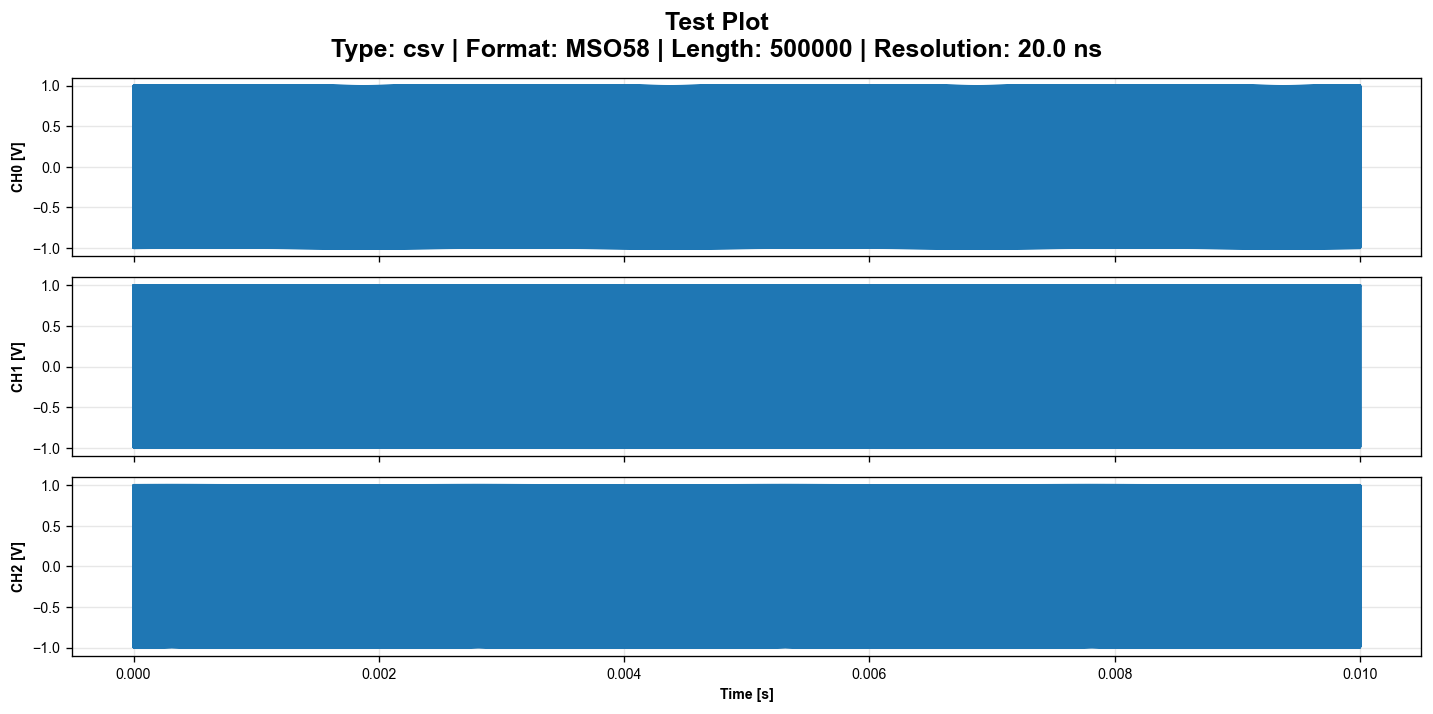


✓ Column names application test complete


In [10]:
# Test 2.2: Plot Column Names Application
print("=" * 80)
print("Test 2.2: Plot Column Names Application")
print("=" * 80)

# Create plot with DataFrame
fig, axes = plotter.plot_waveforms(
    sample_dataframe,
    fs=50e6,
    title="Test Plot",
    show_plot=False,
)

print(f"\nPlot created:")
print(f"  Figure: {fig is not None}")
print(f"  Number of axes: {len(axes)}")
print(f"  Figure size: {fig.get_size_inches()}")

if len(axes) > 0:
    print(f"\n  Axes labels:")
    for i, ax in enumerate(axes):
        xlabel = ax.get_xlabel()
        ylabel = ax.get_ylabel()
        title = ax.get_title()
        print(f"    Axes {i}:")
        print(f"      X-label: '{xlabel}'")
        print(f"      Y-label: '{ylabel}'")
        print(f"      Title: '{title}'")

# Display plot
plt.show()

print("\n✓ Column names application test complete")


Test 2.3: Plot Non-ASCII Exclusion (Korean Characters)

Testing with Korean column name: '한글컬럼'
  DataFrame columns: ['TIME', '한글컬럼', 'CH0']

  ✓ Plot created successfully
    Figure: True
    Number of axes: 2

  Plot text elements:
    Axes 0:
      X-label: '' (contains Korean: False)
      Y-label: '한글컬럼 [V]' (contains Korean: True)
      Title: '' (contains Korean: False)
    Axes 1:
      X-label: 'Time [s]' (contains Korean: False)
      Y-label: 'CH0 [V]' (contains Korean: False)
      Title: '' (contains Korean: False)


C:\Users\dhkdw\Documents\mygit\ifi\ifi\analysis\plots.py:553: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from current font.
  plt.tight_layout()
C:\Users\dhkdw\Documents\mygit\ifi\ifi\analysis\plots.py:553: UserWarning: Glyph 44544 (\N{HANGUL SYLLABLE GEUL}) missing from current font.
  plt.tight_layout()
C:\Users\dhkdw\Documents\mygit\ifi\ifi\analysis\plots.py:553: UserWarning: Glyph 52972 (\N{HANGUL SYLLABLE KEOL}) missing from current font.
  plt.tight_layout()
C:\Users\dhkdw\Documents\mygit\ifi\ifi\analysis\plots.py:553: UserWarning: Glyph 47100 (\N{HANGUL SYLLABLE REOM}) missing from current font.
  plt.tight_layout()
C:\Users\dhkdw\Documents\mygit\ifi\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dhkdw\Documents\mygit\ifi\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44544 (\N{HANGUL SYLLABLE GEUL})

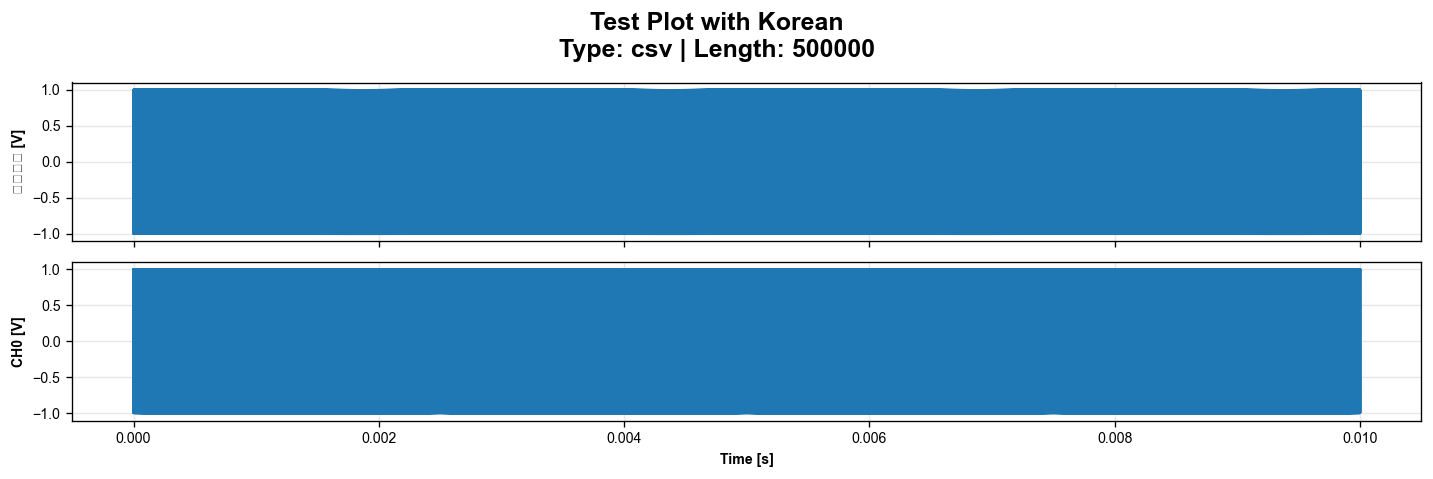


✓ Non-ASCII exclusion test complete


In [11]:
# Test 2.3: Plot Non-ASCII Exclusion
print("=" * 80)
print("Test 2.3: Plot Non-ASCII Exclusion (Korean Characters)")
print("=" * 80)

print(f"\nTesting with Korean column name: '한글컬럼'")
print(f"  DataFrame columns: {list(sample_dataframe_with_korean.columns)}")

try:
    fig, axes = plotter.plot_waveforms(
        sample_dataframe_with_korean,
        fs=50e6,
        title="Test Plot with Korean",
        show_plot=False,
    )
    
    print(f"\n  ✓ Plot created successfully")
    print(f"    Figure: {fig is not None}")
    print(f"    Number of axes: {len(axes)}")
    
    # Check if Korean characters are handled
    print(f"\n  Plot text elements:")
    for i, ax in enumerate(axes):
        xlabel = ax.get_xlabel()
        ylabel = ax.get_ylabel()
        title = ax.get_title()
        print(f"    Axes {i}:")
        print(f"      X-label: '{xlabel}' (contains Korean: {any(ord(c) > 127 for c in xlabel)})")
        print(f"      Y-label: '{ylabel}' (contains Korean: {any(ord(c) > 127 for c in ylabel)})")
        print(f"      Title: '{title}' (contains Korean: {any(ord(c) > 127 for c in title)})")
    
    plt.show()
    
except Exception as e:
    print(f"\n  ⚠ Plotting failed: {e}")
    print(f"    This may be acceptable if non-ASCII is not fully supported")

print("\n✓ Non-ASCII exclusion test complete")


In [ ]:
# Test 2.4: Plot Title Sanitization
print("=" * 80)
print("Test 2.4: Plot Title Sanitization")
print("=" * 80)

test_title = "Shot #45821 - 한글 테스트"
print(f"\nOriginal title: '{test_title}'")

# The sanitization should remove or replace non-ASCII characters
sanitized = "".join(c for c in test_title if c.isalnum() or c in (" ", "_", "-"))
sanitized = sanitized.replace(" ", "_").replace("#", "")

print(f"Sanitized title: '{sanitized}'")

# Check for non-ASCII
has_non_ascii = any(ord(c) > 127 for c in sanitized)
has_hash = "#" in sanitized

print(f"\n  Contains non-ASCII: {has_non_ascii}")
print(f"  Contains #: {has_hash}")

if not has_non_ascii and not has_hash:
    print("  ✓ Sanitization successful")
else:
    print("  ⚠ Sanitization may need improvement")

print("\n✓ Title sanitization test complete")


Test 2.4: Plot Title Sanitization

Original title: 'Shot #45821 - 한글 테스트'
Sanitized title: 'Shot_45821_-_한글_테스트'

  Contains non-ASCII: True
  Contains #: False
  ⚠ Sanitization may need improvement

✓ Title sanitization test complete


## 3. NaN Handling

Test NaN data handling and propagation in mathematical operations.


In [13]:
# Test 3.1: Refine Data NaN Removal
print("=" * 80)
print("Test 3.1: Refine Data NaN Removal")
print("=" * 80)

from ifi.analysis import processing

print(f"\nBefore refinement:")
print(f"  Shape: {sample_dataframe_with_nan.shape}")
print(f"  Total NaN: {sample_dataframe_with_nan.isna().sum().sum()}")
print(f"  NaN per column:")
for col in sample_dataframe_with_nan.columns:
    nan_count = sample_dataframe_with_nan[col].isna().sum()
    print(f"    {col}: {nan_count} NaN values")

# Refine data
refined_df = processing.refine_data(sample_dataframe_with_nan)

print(f"\nAfter refinement:")
print(f"  Shape: {refined_df.shape}")
print(f"  Total NaN: {refined_df.isna().sum().sum()}")
print(f"  Rows removed: {len(sample_dataframe_with_nan) - len(refined_df)}")

if refined_df.isna().sum().sum() == 0:
    print("  ✓ All NaN values removed")
else:
    print(f"  ✗ Still contains NaN: {refined_df.isna().sum().sum()}")

print("\n✓ NaN removal test complete")


Test 3.1: Refine Data NaN Removal

Before refinement:
  Shape: (500000, 3)
  Total NaN: 152
  NaN per column:
    TIME: 0 NaN values
    CH0: 101 NaN values
    CH1: 51 NaN values

After refinement:
  Shape: (499848, 3)
  Total NaN: 0
  Rows removed: 152
  ✓ All NaN values removed

✓ NaN removal test complete


In [ ]:
# Test 3.2: NaN Propagation in Math Operations
print("=" * 80)
print("Test 3.2: NaN Propagation in Mathematical Operations")
print("=" * 80)

# Create arrays with NaN
arr1 = np.array([1.0, 2.0, np.nan, 4.0, 5.0])
arr2 = np.array([1.0, 2.0, 3.0, np.nan, 5.0])

print(f"\nInput arrays:")
print(f"  arr1: {arr1}")
print(f"  arr2: {arr2}")

# Test addition
result_add = arr1 + arr2
print(f"\nAddition (arr1 + arr2):")
print(f"  Result: {result_add}")
print(f"  NaN at index 2: {np.isnan(result_add[2])} (expected: True)")
print(f"  NaN at index 3: {np.isnan(result_add[3])} (expected: True)")
print(f"  Valid at index 0: {not np.isnan(result_add[0])} (expected: True)")

# Test multiplication
result_mul = arr1 * arr2
print(f"\nMultiplication (arr1 * arr2):")
print(f"  Result: {result_mul}")
print(f"  NaN at index 2: {np.isnan(result_mul[2])} (expected: True)")
print(f"  NaN at index 3: {np.isnan(result_mul[3])} (expected: True)")

# Test division
result_div = arr1 / arr2
print(f"\nDivision (arr1 / arr2):")
print(f"  Result: {result_div}")
print(f"  NaN at index 2: {np.isnan(result_div[2])} (expected: True)")
print(f"  NaN at index 3: {np.isnan(result_div[3])} (expected: True)")

print("\n✓ NaN propagation test complete")


Test 3.2: NaN Propagation in Mathematical Operations

Input arrays:
  arr1: [ 1.  2. nan  4.  5.]
  arr2: [ 1.  2.  3. nan  5.]

Addition (arr1 + arr2):
  Result: [ 2.  4. nan nan 10.]
  NaN at index 2: True (expected: True)
  NaN at index 3: True (expected: True)
  Valid at index 0: True (expected: True)

Multiplication (arr1 * arr2):
  Result: [ 1.  4. nan nan 25.]
  NaN at index 2: True (expected: True)
  NaN at index 3: True (expected: True)

Division (arr1 / arr2):
  Result: [ 1.  1. nan nan  1.]
  NaN at index 2: True (expected: True)
  NaN at index 3: True (expected: True)

✓ NaN propagation test complete


In [15]:
# Test 3.3: Phase Calculation with NaN
print("=" * 80)
print("Test 3.3: Phase Calculation with NaN")
print("=" * 80)

from ifi.analysis.phi2ne import PhaseConverter

converter = PhaseConverter()

# Create signals with NaN
i_signal = np.array([1.0, 2.0, np.nan, 4.0, 5.0])
q_signal = np.array([1.0, 2.0, 3.0, np.nan, 5.0])

print(f"\nInput signals:")
print(f"  I signal: {i_signal}")
print(f"  Q signal: {q_signal}")
print(f"  NaN in I: {np.any(np.isnan(i_signal))}")
print(f"  NaN in Q: {np.any(np.isnan(q_signal))}")

# calc_phase_iq_asin2 should handle NaN (converts to 0.0)
phase = converter.calc_phase_iq_asin2(i_signal, q_signal, isnorm=True)

print(f"\nPhase calculation result:")
print(f"  Phase: {phase}")
print(f"  Contains NaN: {np.any(np.isnan(phase))}")
print(f"  Length: {len(phase)}")

if not np.any(np.isnan(phase)):
    print("  ✓ Phase does not contain NaN after processing")
else:
    print(f"  ✗ Phase still contains NaN: {np.sum(np.isnan(phase))} values")

print("\n✓ Phase calculation with NaN test complete")


Test 3.3: Phase Calculation with NaN

Input signals:
  I signal: [ 1.  2. nan  4.  5.]
  Q signal: [ 1.  2.  3. nan  5.]
  NaN in I: True
  NaN in Q: True



Phase calculation result:
  Phase: [4.47422863e-17 4.47422863e-17 4.47422863e-17 4.47422863e-17
 4.47422863e-17]
  Contains NaN: False
  Length: 5
  ✓ Phase does not contain NaN after processing

✓ Phase calculation with NaN test complete


In [16]:
# Test 3.4: STFT with NaN Data
print("=" * 80)
print("Test 3.4: STFT Analysis with NaN Data")
print("=" * 80)

from ifi.analysis.spectrum import SpectrumAnalysis

# Refine data to remove NaN
refined_df = processing.refine_data(sample_dataframe_with_nan)

print(f"\nData after refinement:")
print(f"  Shape: {refined_df.shape}")
print(f"  NaN count: {refined_df.isna().sum().sum()}")

# Calculate STFT
analyzer = SpectrumAnalysis()
fs_calc = 1 / refined_df["TIME"].diff().mean()
signal = refined_df["CH0"].to_numpy()

print(f"\nSTFT parameters:")
print(f"  Signal length: {len(signal)}")
print(f"  Sampling frequency: {fs_calc / 1e6:.2f} MHz")

# STFT should work without NaN
freq_stft, time_stft, stft_matrix = analyzer.compute_stft(signal, fs_calc)

print(f"\nSTFT results:")
print(f"  Frequency bins: {len(freq_stft)}")
print(f"  Time frames: {len(time_stft)}")
print(f"  STFT matrix shape: {stft_matrix.shape}")
print(f"  STFT matrix contains NaN: {np.any(np.isnan(stft_matrix))}")
print(f"  Frequencies contain NaN: {np.any(np.isnan(freq_stft))}")
print(f"  Times contain NaN: {np.any(np.isnan(time_stft))}")

if not np.any(np.isnan(stft_matrix)) and not np.any(np.isnan(freq_stft)) and not np.any(np.isnan(time_stft)):
    print("  ✓ STFT computed successfully without NaN")
else:
    print("  ✗ STFT contains NaN values")

print("\n✓ STFT with NaN data test complete")


Test 3.4: STFT Analysis with NaN Data

Data after refinement:
  Shape: (499848, 3)
  NaN count: 0

STFT parameters:
  Signal length: 499848
  Sampling frequency: 49.98 MHz

STFT results:
  Frequency bins: 4097
  Time frames: 124
  STFT matrix shape: (4097, 124)
  STFT matrix contains NaN: False
  Frequencies contain NaN: False
  Times contain NaN: False
  ✓ STFT computed successfully without NaN

✓ STFT with NaN data test complete


## 4. Enhanced Plotting Features

Test enhanced plotting features with various scaling options.


Test 4.1: Enhanced Plotting Features

Enhanced plot created:
  Figure: True
  Number of axes: 3

  Plot configuration:
    Axes 0:
      X-axis label: ''
      Y-axis label: 'CH0 [mV]'
      ✓ Signal scale (mV) applied
    Axes 1:
      X-axis label: ''
      Y-axis label: 'CH1 [mV]'
      ✓ Signal scale (mV) applied
    Axes 2:
      X-axis label: 'Time [ms]'
      Y-axis label: 'CH2 [mV]'
      ✓ Time scale (ms) applied
      ✓ Signal scale (mV) applied


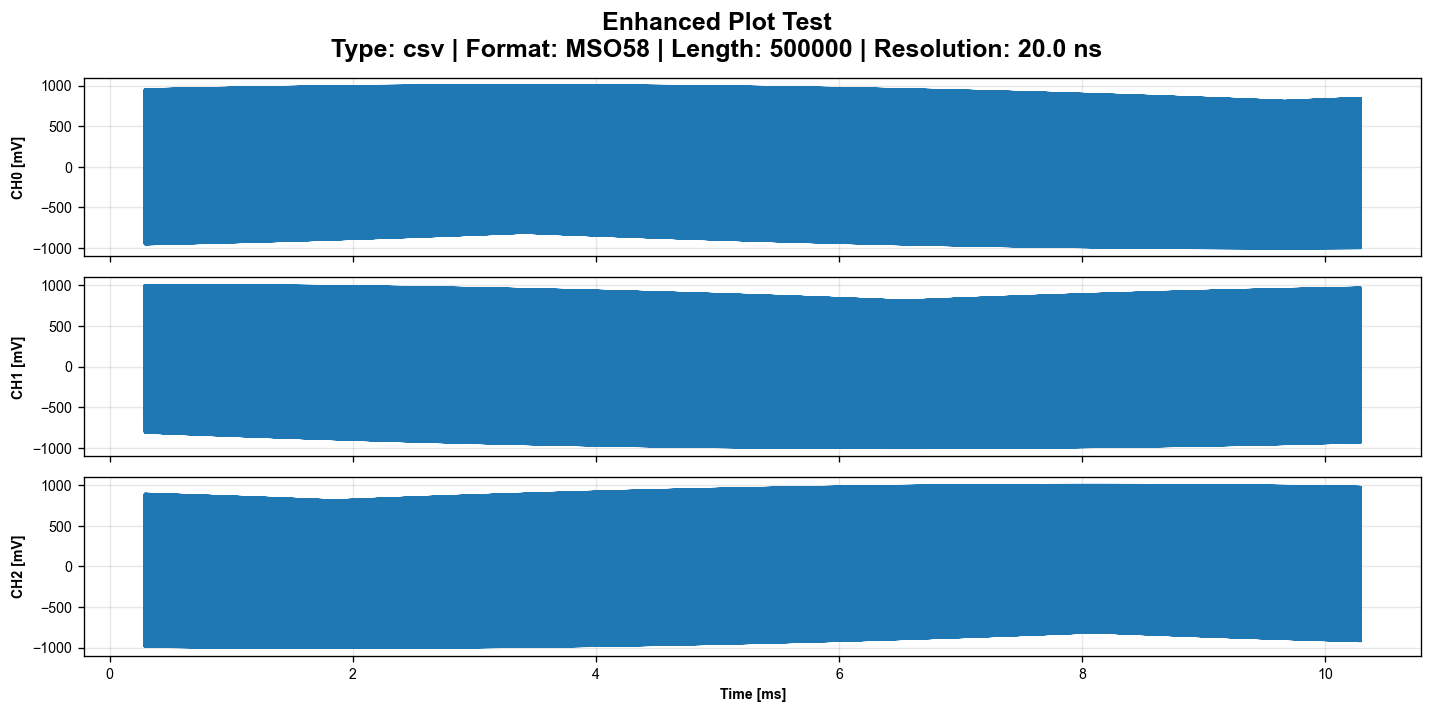


✓ Enhanced plotting features test complete


In [17]:
# Test 4.1: Enhanced Plotting Features
print("=" * 80)
print("Test 4.1: Enhanced Plotting Features")
print("=" * 80)

# Test with various scaling options
fig, axes = plotter.plot_waveforms(
    sample_dataframe,
    fs=50e6,
    title="Enhanced Plot Test",
    show_plot=False,
    time_scale="ms",
    signal_scale="mV",
    trigger_time=0.290,
    downsample=10,
)

print(f"\nEnhanced plot created:")
print(f"  Figure: {fig is not None}")
print(f"  Number of axes: {len(axes)}")

if len(axes) > 0:
    print(f"\n  Plot configuration:")
    for i, ax in enumerate(axes):
        xlabel = ax.get_xlabel()
        ylabel = ax.get_ylabel()
        print(f"    Axes {i}:")
        print(f"      X-axis label: '{xlabel}'")
        print(f"      Y-axis label: '{ylabel}'")
        
        # Check if scaling is applied
        if "ms" in xlabel.lower():
            print(f"      ✓ Time scale (ms) applied")
        if "mv" in ylabel.lower():
            print(f"      ✓ Signal scale (mV) applied")

plt.show()

print("\n✓ Enhanced plotting features test complete")


In [ ]:
# Cleanup
print("Cleaning up temporary files...")
shutil.rmtree(tmp_dir, ignore_errors=True)
print(f"✓ Temporary directory removed: {tmp_dir}")

print("\n" + "=" * 80)
print("All integration tests completed!")
print("=" * 80)


Cleaning up temporary files...
✓ Temporary directory removed: C:\Users\dhkdw\AppData\Local\Temp\tmpumhpz2wi

All integration tests completed!
